### TRAINING NEURAL NETWORK

In this notebook we train an MNLE on model simulations from a specified model.

#### MODEL DESCRIPTION AND SETTINGS

In [1]:
import time
from torch import nn
model_name = "_Master_DDM_120624_Bichoice_"                 # specify the name of the model the simulations are based from in order to distinguish networks by name
prior_description = "_flat_prior_"                          # specify a description of the prior (optional)
training_type = "_combined_training_"                       # specify a description of the training type, is it offline, online, dynamic or a combination? (optional)
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
nn_name = model_name + prior_description + training_type + "_" + timestamp
save_trainer = True                                         # specify whether you actually want to save the network once the training is over
train_offline = True                                        # specify whether you want to use offline training (specifying this in advance allows you to run the notebook in one go without having to choose which cell to run)
train_online = True                                         # specify whether you want to use online training
train_dynamically = True                                    # specify whether you want to use dynamic training

In [2]:
print("This network's timestamp is " + timestamp)

This network's timestamp is Nov-23-2024_1550


#### NETWORK ARCHITECTURE

In [4]:
nn_architecture_dictionary = {}
nn_architecture_dictionary["hidden_features"] = 150
nn_architecture_dictionary["hidden_layers"] = 6
nn_architecture_dictionary["num_categories"] = 2
nn_architecture_dictionary["num_transforms"] = 2
nn_architecture_dictionary["num_bins"] = 24
nn_architecture_dictionary["activation_fun_cnet"] = nn.SELU()
nn_architecture_dictionary["log_transform_x"] = False

#### GENERAL IMPORTS

In [11]:
# This file is part of sbi, a toolkit for simulation-based inference. sbi is licensed
# under the Affero General Public License v3, see <https://www.gnu.org/licenses/>.


import contextlib
from typing import Callable, Optional

import joblib
import torch
from joblib import Parallel, delayed
from torch import Tensor
from tqdm.auto import tqdm

def seed_all_backends(seed: Optional[int] = None) -> None:
    """Sets all python, numpy and pytorch seeds."""

    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore


def simulate_in_batches(
    simulator: Callable,
    theta: Tensor,
    sim_batch_size: int = 1,
    num_workers: int = 1,
    seed: Optional[int] = None,
    show_progress_bars: bool = True,
) -> Tensor:
    r"""
    Return simulations $x$ for parameters $\theta$ conducted batchwise.

    Parameters are batched with size `sim_batch_size` (default whole theta at once).
    Multiprocessing is used when `num_workers > 1`.

    Args:
        simulator: Simulator callable (a function or a class with `__call__`).
        theta: All parameters $\theta$ sampled from prior or posterior.
        sim_batch_size: Number of simulations per batch. Default is to simulate
            the entire theta in a single batch. When using multiple workers, increasing
            this batch size can further speed up simulations by reducing overhead.
        num_workers: Number of workers for multiprocessing.
        seed: seed for reproducibility.
        show_progress_bars: Whether to show a progress bar during simulation.

    Returns:
        Parameters theta and simulations $x$.
    """

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        # Dev note: pyright complains of torch.split lacking a type stub
        # as of PyTorch 1.4.0, see https://github.com/microsoft/pyright/issues/291
        batches = torch.split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = torch.randint(high=1_000_000, size=(len(batches),))

            # define seeded simulator.
            def simulator_seeded(theta: Tensor, seed) -> Tensor:
                seed_all_backends(seed)
                return simulator(theta)

            # Parallelize the sequence of batches across workers.
            # We use the solution proposed here: https://stackoverflow.com/a/61689175
            # to update the pbar only after the workers finished a task.
            with tqdm_joblib(
                tqdm(
                    batches,
                    disable=not show_progress_bars,
                    desc=f"Running {num_sims} simulations in {len(batches)} batches.",
                    total=len(batches),
                )
            ) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(
                    delayed(simulator_seeded)(batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds)
                )
        else:
            pbar = tqdm(
                total=num_sims,
                disable=not show_progress_bars,
                desc=f"Running {num_sims} simulations.",
            )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator(batch))
                    pbar.update(sim_batch_size)

        x = torch.cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as
    argument

    This wrapped context manager obtains the number of finished tasks from the tqdm
    print function and uses it to update the pbar, as suggested in
    https://stackoverflow.com/a/61689175. See #419, #421
    """

    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

In [12]:
from sbi.inference import MNLE
import numpy as np
import dill
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import sys

#### MODEL AND PRIOR IMPORTS

In [15]:
# from simulators.master_ddm_120624_A_bichoice import Master_DDM
# from priors.master_ddm_120624_prior_A import prior, proposal
from fillipe_code import Master_DDM, prior, proposal

ModuleNotFoundError: No module named 'ddm_models'

In [27]:
from utils.simulate import Master_DDM_2Dx
from utils.metrics import generate_metrics_dictionary, visualise_mnle

In [28]:
simulator = Master_DDM()
simulator_2D_x = Master_DDM_2Dx(simulator=simulator)

#### TRAINING METRICS SETTINGS

In [29]:
metrics_dictionary = generate_metrics_dictionary(likelihood=None, prior=proposal, simulator=simulator_2D_x, save_metrics=False, max_test_time=1.5)

#### GENERATE SIMULATIONS FOR VALIDATION PURPOSES

In [30]:
num_simulations = 10**5
n_cores = 1*cpu_count()

# Simulate parameter-data pairs:
theta, x = simulate_for_sbi_truncated(simulator=simulator_2D_x, proposal=proposal, num_simulations=num_simulations, num_workers=n_cores-1)

Running 100000 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Running 3975 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Running 175 simulations in 88 batches.:   0%|          | 0/88 [00:00<?, ?it/s]

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

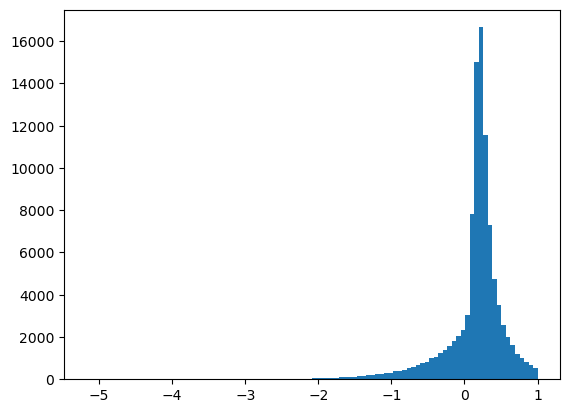

In [31]:
plt.hist(x[:,0], bins=100);

#### TRAINING

In [32]:
# Define network architecure 
trainer = MNLE(
            proposal = proposal,
            prior = prior,
            likelihood = None,
            simulator = simulator_2D_x,
            hidden_features = nn_architecture_dictionary["hidden_features"],
            hidden_layers = nn_architecture_dictionary["hidden_layers"],
            num_categories = nn_architecture_dictionary["num_categories"],
            num_transforms = nn_architecture_dictionary["num_transforms"], 
            num_bins = nn_architecture_dictionary["num_bins"],
            activation_fun_cnet = nn_architecture_dictionary["activation_fun_cnet"],
            log_transform_x = nn_architecture_dictionary["log_transform_x"],
        )

# And load simulations
trainer.append_simulations(theta=theta,x=x)

##### OFFLINE (Skip to ONLINE or DYNAMIC if not using it)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


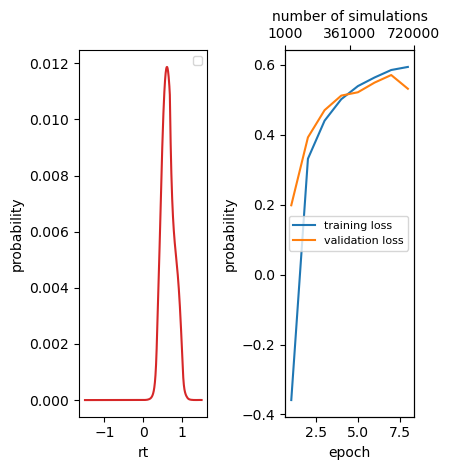

 Neural network successfully converged after 8 epochs.

In [33]:
if train_offline:

    # Unload and reload simulations - this tells the network we are still in the first round of training and can follow online training with dynamic training
    trainer.un_append_simulations()
    trainer.append_simulations(theta=theta,x=x)
    trainer._summary["training_log_probs"] = []     # reset training log probs so that we can plot losses from scratch
    trainer._summary["validation_log_probs"] = []   # reset training log probs so that we can plot losses from scratch

    trainer.train_offline(
        training_batch_size=1000,           # number of simulations per network update
        max_num_simulations=5*10**9,        # number of simulations (accumulated over epochs) at which training will stop 
        stop_after_epochs=1,                # number of epochs without improvement at which training will stop
        metrics_dictionary=metrics_dictionary, 
        show_train_plot=True,
        visualise_mnle=visualise_mnle,
        resume_training=False,
        )

##### ONLINE (Skip to DYNAMIC if not using it)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


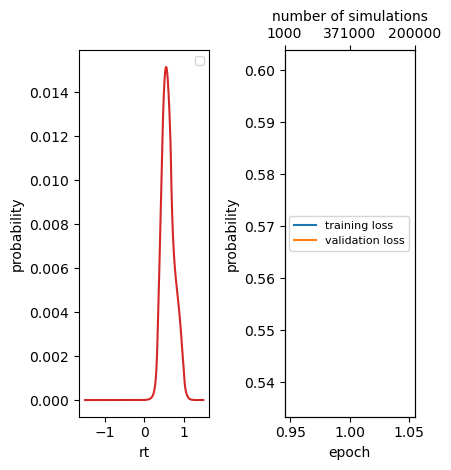

 Training neural network. Epochs trained: 1

In [34]:
if train_online:

    # Unload and reload simulations - this tells the network we are still in the first round of training and can follow online training with dynamic training
    trainer.un_append_simulations()
    trainer.append_simulations(theta=theta,x=x)
    trainer._summary["training_log_probs"] = []     # reset training log probs so that we can plot losses from scratch
    trainer._summary["validation_log_probs"] = []   # reset training log probs so that we can plot losses from scratch

    trainer.train_online_truncated(
        training_batch_size=10**4,     # number of simulations per network update
        num_simulations=10**5,         # number of simulations per epoch
        max_num_simulations=10**5,     # number of simulations (accumulated over epochs) at which training will stop 
        metrics_dictionary=metrics_dictionary, 
        show_train_plot=True,
        visualise_mnle=visualise_mnle,
        resume_training=False,
        )

##### DYNAMIC 

In [35]:
bs0 = 10**3                 # initial number of simulations used per network update
max_bs = 10**5  #6          # maximum number of simulations used per network update
max_nsim = 10**5#  7        # number of simulations (accumulated over epochs) at which training will stop 
monitoring_int = 10         # how often you compute the validation probability (eg: 10 means that we only compute the validation probability every 10 epochs of training, which speeds up training)

In [36]:
if train_dynamically:

    # Unload and reload simulations
    trainer.un_append_simulations()
    trainer.append_simulations(theta=theta,x=x)
    trainer._summary["training_log_probs"] = []
    trainer._summary["validation_log_probs"] = []

    trainer.train_dynamically_truncated(
        starting_training_batch_size=bs0,      # initial number of simulations used per network update
        max_training_batch_size=max_bs,        # maximum number of simulations used per network update
        max_num_simulations=max_nsim,          # number of simulations (accumulated over epochs) at which training will stop 
        training_rate=((bs0)/(max_nsim))**2,   # it's tricky to know in advance what training rate works best, ((starting_training_batch_size)/(max_num_simulations))**2 is usually okay
        stop_after_epochs=10**10,              # if you want to impose a limit on how many epochs of training take place
        metrics_dictionary=metrics_dictionary, 
        monitoring_interval=monitoring_int,    # how often you compute the validation probability 
        show_train_plot=True,
        visualise_mnle=visualise_mnle,
        rectify_loss = False,
        resume_training = False,
    )

 Training neural network. Epochs trained: 81

Running 1386 simulations in 99 batches.:   0%|          | 0/99 [00:00<?, ?it/s]

Running 58 simulations in 58 batches.:   0%|          | 0/58 [00:00<?, ?it/s]

Running 1395 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Running 71 simulations in 71 batches.:   0%|          | 0/71 [00:00<?, ?it/s]

Running 1410 simulations in 94 batches.:   0%|          | 0/94 [00:00<?, ?it/s]

Running 57 simulations in 57 batches.:   0%|          | 0/57 [00:00<?, ?it/s]

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Running 1425 simulations in 95 batches.:   0%|          | 0/95 [00:00<?, ?it/s]

Running 52 simulations in 52 batches.:   0%|          | 0/52 [00:00<?, ?it/s]

Running 2 simulations in 2 batches.:   0%|          | 0/2 [00:00<?, ?it/s]

Running 1425 simulations in 95 batches.:   0%|          | 0/95 [00:00<?, ?it/s]

Running 70 simulations in 70 batches.:   0%|          | 0/70 [00:00<?, ?it/s]

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Running 1440 simulations in 96 batches.:   0%|          | 0/96 [00:00<?, ?it/s]

Running 56 simulations in 56 batches.:   0%|          | 0/56 [00:00<?, ?it/s]

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

#### VISUALISE TRAINING AND VALIDATION LOSSES

In [37]:
lps_mnle_train = trainer._summary["training_log_probs"][::monitoring_int]
lps_mnle_val = trainer._summary["validation_log_probs"]

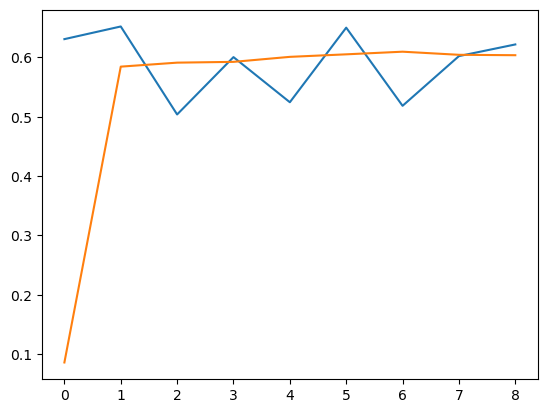

In [38]:
plt.plot(lps_mnle_train)
plt.plot(lps_mnle_val)

#### SAVE TRAINER

In [39]:
trainers_folder = [path for path in sys.path if r'trainers' in path][0]

In [40]:
if save_trainer: 
    ### SAVING ### 
    filename = nn_name
    filepath = trainers_folder + filename

    # Save the file
    with open(filepath, 'wb') as f:
        try: 
            dill.dump(trainer, f)
        except:
            # in case of Julia log likelihood function
            trainer._likelihood = None
            dill.dump(trainer, f)

/home/filipe/Documents/GitHub/sbi/sbi/inference/base.py:1162: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  warn(
